In [2]:
from oxasl_all import images, outdir_forimg, SUBJECT_SESSIONS, SUBJECT_SESSIONS2
import os.path as op 
import nibabel
import numpy as np 
import seaborn as sea
import matplotlib.pyplot as plt 
import scipy 
import xarray as xr
from IPython.core.debugger import set_trace
import itertools
import pickle
import analysis_scripts as ascripts 
from analysis_scripts import x_array, RMS, percent_diff
import sys 

cmap = np.array(plt.get_cmap('tab10').colors)
niiload = lambda path: nibabel.load(path).get_fdata().flatten()
TISSUES = ['GM', 'WM']
METHODS = ['Tob', 'FAST']
PSFS = ['no PSF', 'PSF']
PVC = ['no PVC', 'PVC']
BASES = ['self', 'GM']

saveargs = {'dpi': 300}

/home/ibmeuser/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ibmeuser/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
split_images = []
n_images = len(images)
for (sub,sess,img) in images[0:n_images]: 
    
    if 'task' not in img: 
        split_images.append((sub,sess,img))
    else: 
        split_images.append((sub,sess,img+'_task'))
        split_images.append((sub,sess,img+'_rest'))
        
        
def load_fast_pvs(odir):
    return [ niiload(op.join(odir, 'structural', '%s_pv_asl.nii.gz' % t))
              for t in ['gm', 'wm'] ]

def load_tob_pvs(odir):
    return [ niiload(op.join(odir, 'surf_pvs', '%s.nii.gz' % t))
          for t in ['GM', 'WM'] ]

def load_cbfs(odir):
    return [ niiload(op.join(odir, 'native', 'perfusion_%scalib.nii.gz' % suff))
        for suff in ['', 'wm_'] ]

dbin_edges, dbin_cents = ascripts.make_hist_bins(20,-1,1)
hist_bins = np.linspace(0,1,21)
bin_cents = hist_bins[1:] - (0.5 * hist_bins[1])
BAR_MIN = 1
BAR_SEP = hist_bins[1]
PLOT_BINS = bin_cents[BAR_MIN:]
BIN_LABELS = ['%2.1f' % (100*x) for x in PLOT_BINS]


pv_hist = x_array(dims=('img', 'meth', 'tiss', 'bin', 'psf'), 
                  coords={'img': range(len(split_images)), 'meth': METHODS, 
                         'tiss': TISSUES, 'bin': range(bin_cents.size), 'psf': PSFS})

cbfs = x_array(dims=('img', 'meth', 'tiss', 'bin', 'pvc', 'psf'), 
             coords={'img': range(len(split_images)), 'meth': METHODS, 
                         'tiss': TISSUES, 'bin': range(bin_cents.size), 'pvc': PVC, 'psf': PSFS})

cbf_diffs = x_array(coords={'img': range(len(split_images)), 'tiss': TISSUES, 'bin': range(bin_cents.size)})

pv_diffs = x_array(coords={'img': range(len(split_images)),'tiss': TISSUES, 'bin': range(bin_cents.size)})

cbf_pv_diff = x_array(coords={'img': range(len(split_images)), 'basis': BASES, 'tiss': TISSUES, 'bin': range(bin_cents.size)})

covs = x_array(coords={'img': range(len(split_images)), 'meth': METHODS, 
                         'tiss': TISSUES, 'bin': range(bin_cents.size), 'pvc': PVC})

In [13]:
for idx,(sub,sess,img) in enumerate(split_images): 
    
    od = outdir_forimg(sub,sess,img)        
    
    fastpvs = load_fast_pvs(od)
    tobpvs = load_tob_pvs(od)
    mask = (tobpvs[0] > 0.01) | (tobpvs[1] > 0.01)
    masksize = mask.sum() 
        
    for psf in ['no PSF']: 

        if psf == 'PSF':
            fdir = od + '_fast_psf/output_pvcorr'
            tdir = od +'_tob_psf/output_pvcorr'
        else: 
            fdir = op.join(od, 'output_pvcorr')
            tdir = op.join(od, 'output_surf_pvcorr')
            
        cbf = niiload(op.join(od, 'output', 'native', 'perfusion_calib.nii.gz'))
        tobcbfs = load_cbfs(tdir)
        fastcbfs = load_cbfs(fdir)
   
        for tiss,tpv,fpv,tcbf,fcbf in zip(TISSUES, tobpvs, fastpvs, tobcbfs, fastcbfs):
            
            t_binned = np.digitize(tpv[mask], hist_bins, right=True)
            f_binned = np.digitize(fpv[mask], hist_bins, right=True)

            for bidx in range(bin_cents.size):
                pv_hist.loc[idx,'Tob',tiss,bidx,psf] = (t_binned == bidx+1).sum() / masksize
                pv_hist.loc[idx,'FAST',tiss,bidx,psf] = (f_binned == bidx+1).sum() / masksize

                if (t_binned==bidx+1).any():
                    t_cbf_nopvc = cbf[mask][t_binned==bidx+1]
                    t_cbf_pvc = tcbf[mask][t_binned==bidx+1]
                    cbfs.loc[idx,'Tob',tiss,bidx,'no PVC',psf] = t_cbf_nopvc.mean()
                    covs.loc[idx,'Tob',tiss,bidx,'no PVC'] = t_cbf_nopvc.std() / t_cbf_nopvc.mean()
                    cbfs.loc[idx,'Tob',tiss,bidx,'PVC',psf] = t_cbf_pvc.mean()
                    covs.loc[idx,'Tob',tiss,bidx,'PVC'] = t_cbf_pvc.std() / t_cbf_pvc.mean()

                    
                if (f_binned==bidx+1).any(): 
                    f_cbf_nopvc = cbf[mask][f_binned==bidx+1]
                    f_cbf_pvc = fcbf[mask][f_binned==bidx+1]
                    cbfs.loc[idx,'FAST',tiss,bidx,'no PVC',psf] = f_cbf_nopvc.mean()
                    covs.loc[idx,'FAST',tiss,bidx,'no PVC'] = f_cbf_nopvc.std() / f_cbf_nopvc.mean()
                    cbfs.loc[idx,'FAST',tiss,bidx,'PVC',psf] = f_cbf_pvc.mean()
                    covs.loc[idx,'FAST',tiss,bidx,'PVC'] = f_cbf_pvc.std() / f_cbf_pvc.mean()

                if (psf != 'PSF') and (tiss == 'GM'):
                    for tidx,t in enumerate(TISSUES):
                        cbf_diffs.loc[idx,t,bidx] = \
                            ((tobcbfs[tidx] - fastcbfs[tidx])[mask][t_binned == bidx+1]).mean()
                        pv_diffs.loc[idx,t,bidx] = \
                            ((tobpvs[tidx] - fastpvs[tidx])[mask][t_binned == bidx+1]).mean()
                        
                    pv_diffs.loc[idx,tiss,bidx] = ((tpv-fpv)[mask][t_binned==bidx+1]).mean()
                    cbf_diffs.loc[idx,tiss,bidx] = ((tcbf-fcbf)[mask][t_binned==bidx+1]).mean()
                    
                    
        for basis in BASES:
            for tidx,t in enumerate(TISSUES):
                if basis == 'GM':
                    pv_diff = np.digitize((tobpvs[0] - fastpvs[0])[mask], dbin_edges, right=True)
                else: 
                    pv_diff = np.digitize((tobpvs[tidx] - fastpvs[tidx])[mask], dbin_edges, right=True)
                    
                cbf_diff = (tobcbfs[tidx] - fastcbfs[tidx])[mask]
#                 set_trace()
                for bidx in range(dbin_cents.size):
                    bmask = (pv_diff==bidx+1)
                    if bmask.any():
                        val = cbf_diff[pv_diff==bidx+1].mean()
                    else:
                        val = 0 
                    cbf_pv_diff.loc[idx,basis,t,bidx] = val 
                    

if not sys.platform.startswith('darwin'):
    with open('data.pkl', 'wb') as f:
        pickle.dump([pv_hist, cbfs, pv_diffs, cbf_diffs, cbf_pv_diff], f)

NameError: name 'sys' is not defined

In [3]:
with open('data.pkl', 'rb') as f: 
    pv_hist, cbfs, pv_diffs, cbf_diffs, cbf_pv_diff = pickle.load(f)

In [4]:
# sess_repeats = [] 
# for sub in range(1,8):
#     for sess in ['A', 'B', 'C']:
#         r1 = ('%02.0f' % sub, sess, 'rest1')
#         r2 = ('%02.0f' % sub, sess, 'rest2')
#         if (r1 in split_images) and (r2 in split_images):
#             sess_repeats.append([r1,r2])
            
# sessions = {'A', 'B', 'C'}
# week_repeats = {}
# for sub in range(1,8):
#     for s1 in sessions:
#         r1 = ('%02.0f' % sub, s1, 'rest1')
#         sess_remain = sessions.difference([s1])
#         for s2 in sess_remain:
#             r2 = ('%02.0f' % sub, s2, 'rest1')
#             if (r1 in split_images) and (r2 in split_images):
#                 if sub not in week_repeats:
#                     if s2 > s1:
#                         week_repeats[sub] = (r1,r2)    
#                     else: 
#                         week_repeats[sub] = (r2,r1)

In [5]:
# sess_rpt_data = np.zeros((len(sess_repeats), 2, 3))
# week_rpt_data = np.zeros((len(week_repeats.keys()), 2, 3))
# gm_threshold = 0.5

# for idx,(s1,s2) in enumerate(sess_repeats):     
#     for sidx,s in enumerate([s1,s2]):
#         od = outdir_forimg(*s)
#         odpvc = od + '_pvcorr' 
#         fastgm, fastwm = load_fast_pvs(odpvc)
#         tobgm, tobwm = load_tob_pvs(odpvc)
#         cbf = niiload(op.join(od, 'output', 'native', 'perfusion_calib.nii.gz'))
#         tobcbf, tobwmcbf = load_tob_cbf(odpvc)
#         fastcbf, fastwmcbf = load_fast_cbf(odpvc)
        
#         tmask = (tobgm >= gm_threshold)
#         fmask = (fastgm >= gm_threshold)
#         sess_rpt_data[idx,sidx,0] = tobcbf[tmask].mean()
#         sess_rpt_data[idx,sidx,1] = fastcbf[fmask].mean()
#         sess_rpt_data[idx,sidx,2] = cbf[fmask].mean()
        
# for idx,(s1,s2) in enumerate(week_repeats.values()):     
#     for sidx,s in enumerate([s1,s2]):
#         od = outdir_forimg(*s)
#         odpvc = od + '_pvcorr' 
#         fastgm, fastwm = load_fast_pvs(odpvc)
#         tobgm, tobwm = load_tob_pvs(odpvc)
#         cbf = niiload(op.join(od, 'output', 'native', 'perfusion_calib.nii.gz'))
#         tobcbf, tobwmcbf = load_tob_cbf(odpvc)
#         fastcbf, fastwmcbf = load_fast_cbf(odpvc)
        
#         tmask = (tobgm >= gm_threshold)
#         fmask = (fastgm >= gm_threshold)
#         week_rpt_data[idx,sidx,0] = tobcbf[tmask].mean()
#         week_rpt_data[idx,sidx,1] = fastcbf[fmask].mean()
#         week_rpt_data[idx,sidx,2] = cbf[fmask].mean()

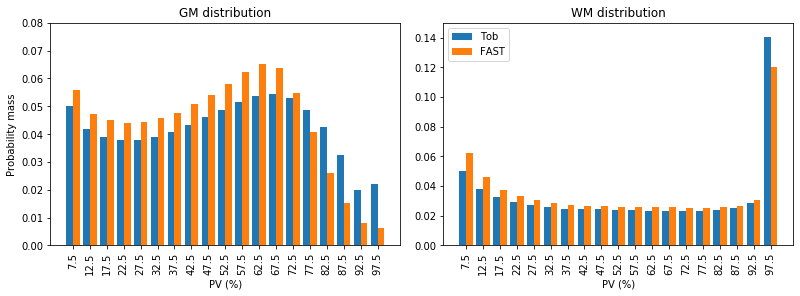

In [21]:
fig, axes = plt.subplots(1, 2, constrained_layout=True) 
fig.set_size_inches(11,4)

for idx,tiss in enumerate(TISSUES):
    
    tobhist = pv_hist.loc[:,'Tob',tiss,BAR_MIN:,'no PSF']
    fasthist = pv_hist.loc[:,'FAST',tiss,BAR_MIN:,'no PSF']

    ax = axes[idx]
    ax.bar(x=PLOT_BINS - 0.01, 
            height=tobhist.mean('img'), width = 0.02)

    ax.bar(x=PLOT_BINS + 0.01, 
            height=fasthist.mean('img'), width = 0.02)
    
    ax.set_xticks(PLOT_BINS)
    ax.set_xticklabels(BIN_LABELS, rotation=90)
    ax.set_xlabel('PV (%)')
    if tiss == 'GM': 
        ax.set_ylabel('Probability mass')
        ax.set_ylim(0, 0.08)
    else: 
        ax.set_ylim(0, 0.15)
    ax.set_title('%s distribution' % tiss)

plt.legend(METHODS)
plt.savefig('figs/histogram.png', **saveargs)
plt.show()

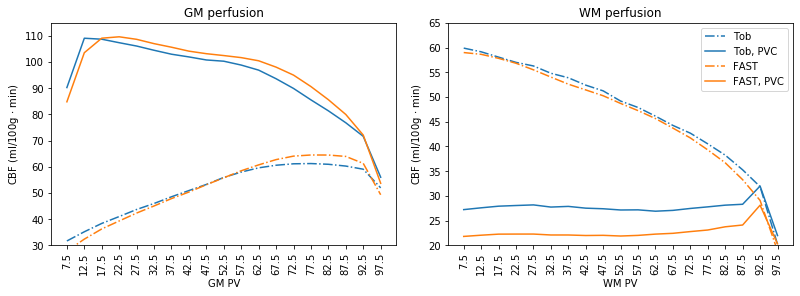

In [23]:
fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(11,4)

for ax,(idx,tiss) in zip(axes.flat, enumerate(TISSUES)):
    psf = 'no PSF'

    tob_nopvc, tob_pvc = (cbfs.loc[:,'Tob',tiss,BAR_MIN:,:,psf].mean('img')).T
    fast_nopvc, fast_pvc = (cbfs.loc[:,'FAST',tiss,BAR_MIN:,:,psf].mean('img')).T

    ax.plot(PLOT_BINS, tob_nopvc, c=cmap[0,:], linestyle='-.', label='Tob')
    ax.plot(PLOT_BINS, tob_pvc, c=cmap[0,:], label='Tob, PVC')
    ax.plot(PLOT_BINS, fast_nopvc, c=cmap[1,:], linestyle='-.', label='FAST')
    ax.plot(PLOT_BINS, fast_pvc, c=cmap[1,:], label='FAST, PVC')
    
    ax.set_title('%s perfusion' % (tiss))
    ax.set_xlabel(tiss + ' PV')
    ax.set_ylabel(r'CBF (ml/100g $\cdot$ min)')
    
    if tiss == 'GM':
        ax.set_ylim(30, 115)
    else:   
        ax.set_ylim(20, 65)
    
    if idx < 2 and False: 
        ax.set_xticks([])
    else: 
        ax.set_xticks(PLOT_BINS)
        ax.set_xticklabels(BIN_LABELS, rotation=90)

ax.legend()
plt.savefig('figs/cbf.png', dpi=500)
plt.show()


# The drop off of PV corrected CBF at high PVs - could be a different source of confound becomes more 
# significant eg PSF. We could test this by convolving PV maps with a PSF to match that of our data, 
# then we would hope to see the PV curves stay flat at the top end. Blur with PSF but retain original 
# maps for drawing the graphs 

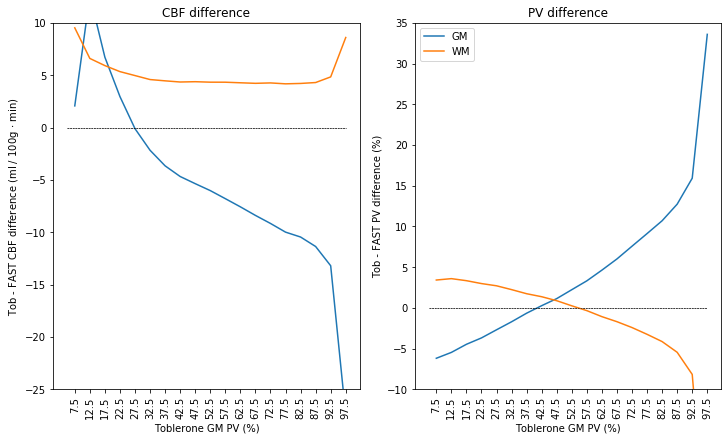

In [8]:
markers = ["o", "D", "*"]
styles = ["-", "-.", ":"]

fig, axes = plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(10,6)

for ax in axes: 
    ax.set_xlabel("Toblerone GM PV (%)")
    ax.set_xticks(PLOT_BINS)
    ax.set_xticklabels(BIN_LABELS, rotation=90)

ax = axes[0]
ax.set_title('CBF difference')
ax.set_ylabel(r"Tob - FAST CBF difference (ml / 100g $\cdot$ min)")
ax.set_ylim(-25,10)   

for tidx,tiss in enumerate(TISSUES): 
    y = cbf_diffs.loc[:,tiss,1:].mean('img')
    ax.plot(PLOT_BINS, y, c=cmap[tidx,:], label=tiss)
    ax.plot([0.05,0.975],[0,0],'k--',linewidth=0.5)
    
ax = axes[1]
ax.set_ylim(-10, 35)
ax.set_ylabel('Tob - FAST PV difference (%)')
ax.set_title('PV difference')

for tidx,tiss in enumerate(TISSUES): 
    y = 100 * pv_diffs.loc[:,tiss,1:].mean('img')
    ax.plot(PLOT_BINS, y, c=cmap[tidx,:], label=tiss)
    ax.plot([0.05,0.975],[0,0],'k--',linewidth=0.5)

         
ax.legend()
plt.savefig('figs/cbf_pv_diff.png', **saveargs)
plt.show()

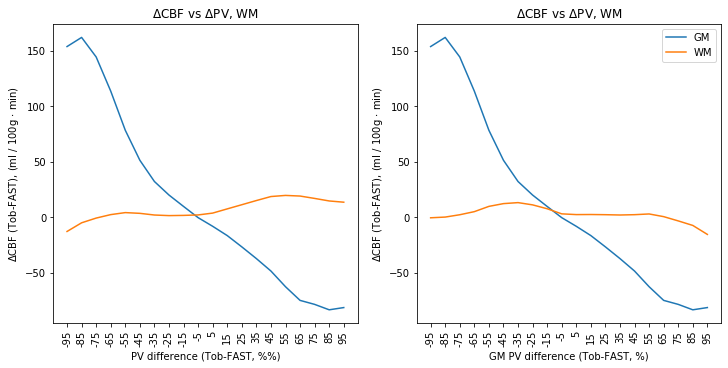

In [9]:
fig, axes = plt.subplots(1, 2, constrained_layout=True)
fig.set_size_inches(10,5)

for basis,ax in zip(BASES, axes.flat):
    for tiss in TISSUES: 
        y = cbf_pv_diff.loc[:,basis,tiss,:].mean('img')
        ax.plot(dbin_cents, y, label=tiss)
    ax.set_title(r"$\Delta$CBF vs $\Delta$PV, "+ tiss)
    ax.set_ylabel(r"$\Delta$CBF (Tob-FAST), (ml / 100g $\cdot$ min)")
    if basis == 'self':
        ax.set_xlabel("PV difference (Tob-FAST, %%)")
    else: 
        ax.set_xlabel("GM PV difference (Tob-FAST, %)")
    ax.set_xticks(dbin_cents)
    ax.set_xticklabels(["%i" % round(100*d) for d in dbin_cents], rotation=90)

ax.legend()
plt.savefig('figs/cbf_vs_pv_diff.png', **saveargs)
plt.show()

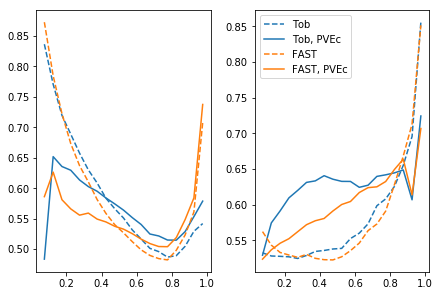

In [15]:
fig,axes = plt.subplots(1,2,constrained_layout=True)

for tiss,ax in zip(TISSUES, axes.flat): 
    
    for meth,col in zip(METHODS,cmap):
        y = covs.loc[:,meth,tiss,BAR_MIN:,'no PVC'].mean('img')
        ax.plot(PLOT_BINS, y, color=col, linestyle='--', label=meth)
        
        y = covs.loc[:,meth,tiss,BAR_MIN:,'PVC'].mean('img')
        ax.plot(PLOT_BINS, y, color=col, label=('%s, PVEc' % meth))

plt.legend()
plt.show()

In [14]:
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(111)
# LIMS = [40,80]
# ax.plot(LIMS, LIMS)

# d_handles = []
# d_labels = ['Tob', 'FAST', 'No PVEc']
# for i in range(3):
#     x = week_rpt_data[:,0,i]
#     y = week_rpt_data[:,1,i]
#     lr = scipy.stats.linregress(x,y)
#     d_labels[i] = d_labels[i] + ', m=%0.2f, r=%0.2f' % (lr.slope, lr.rvalue)
#     d_handles.append(plt.scatter(x,y, s=50))
#     plt.plot(x, lr.intercept + lr.slope*x, 'r', label='fitted line')

# plt.title('Week repeats')
# plt.xlabel('Mean CBF, week 1')
# plt.ylabel('Mean CBF, week 2')
# plt.legend(d_handles, d_labels)
# plt.show()

In [11]:
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(111)
# LIMS = [40,80]
# ax.plot(LIMS, LIMS)

# d_handles = []
# d_labels = ['Tob', 'FAST', 'No PVEc']
# for i in range(3):
#     x = sess_rpt_data[:,0,i]
#     y = sess_rpt_data[:,1,i]
#     lr = scipy.stats.linregress(x,y)
#     d_labels[i] = d_labels[i] + ', m=%0.2f, r=%0.2f' % (lr.slope, lr.rvalue)
#     d_handles.append(plt.scatter(x,y, s=50))
#     plt.plot(x, lr.intercept + lr.slope*x, 'r', label='fitted line')

    
# plt.title('Session repeats')
# plt.xlabel('Mean CBF, rest 1')
# plt.ylabel('Mean CBF, rest 2')
# plt.legend(d_handles, d_labels)
# plt.show()

In [12]:
# plt.figure(figsize=(10,10))

# for tidx,tiss in enumerate(TISSUES):
#     tob_diff = cbf_diffs[:,tidx,:].mean(0)
#     fast_diff = cbf_diffs[:,tidx,1,:].mean(0)
    
#     ax = plt.subplot(2,1,tidx+1)
#     ax.plot(PLOT_BINS, tob_diff[BAR_MIN:], 'r')
#     ax.plot(PLOT_BINS, fast_diff[BAR_MIN:], 'b')
    
#     ax.set_xticks([])
#     ax.set_title('Mean perfusion difference after PVEc, ' + tiss)
#     ax.set_xlabel(tiss + ' PV')
#     ax.set_ylabel(r'$\Delta CBF (\%)$')
    
# ax.set_xticks(PLOT_BINS)
# ax.set_xticklabels(BIN_LABELS, rotation=90)
# ax.legend(['Tob', 'FAST'])
# plt.show()

# The increase in PVEc WM perfusion at high WM CBFs - this could be because some WM voxels lie close to GM structures
# eg cortex and therefore have higher CBF to begin with, compared to very pure WM voxels which are deep in the brain 
# and therefore have low perfusion to start with. Could also be some smoothing artefacts between these regions